# Imports

In [1]:

import os
import sys
import time
import pandas as pd
from IPython.display import display

# Get the current working directory (where the notebook is running from)
notebook_dir = os.getcwd()
# Go up 1 level to reach the 'clustering' project root
root_path = os.path.abspath(os.path.join(notebook_dir, '../'))
if root_path not in sys.path:
    sys.path.insert(0, root_path)
    
# Clustering methods
from clustering_methods import (
    kmeans_clustering, meanshift_clustering, dbscan_clustering,
    agglomerative_clustering, gmm_clustering, spectral_clustering,
    constrained_kmeans_clustering, copk_means_clustering, hdbscan_clustering, 
    seeded_k_means_clustering, novel_clustering, dec_clustering
)

# Plotting
from utilities.plotting import plot_clusters
from utilities.cluster_utilities import (load_dataset, 
                                         save_df
)

# Evaluation metrics
from utilities.evaluation_metrics import (
    compute_accuracy, compute_purity, compute_homogeneity, compute_ari,
    compute_completeness, compute_v_measure, compute_nmi,
    compute_fmi,
    compute_silhouette, compute_davies_bouldin,
    compute_calinski_harabasz
)

# Dataset Configuration, Loading and Plotting

In [5]:
# Output directory
results_folder = 'results'
os.makedirs(results_folder, exist_ok=True)

num_clusters = None  
plot_title = None
random_seed = 366 #np.random.randint(0, 10000)
gauss_feature_numbers = 2 

Number of labelled examples: 100
Number of unlabelled examples: 9900
Percentage of labelled data: 1.00%


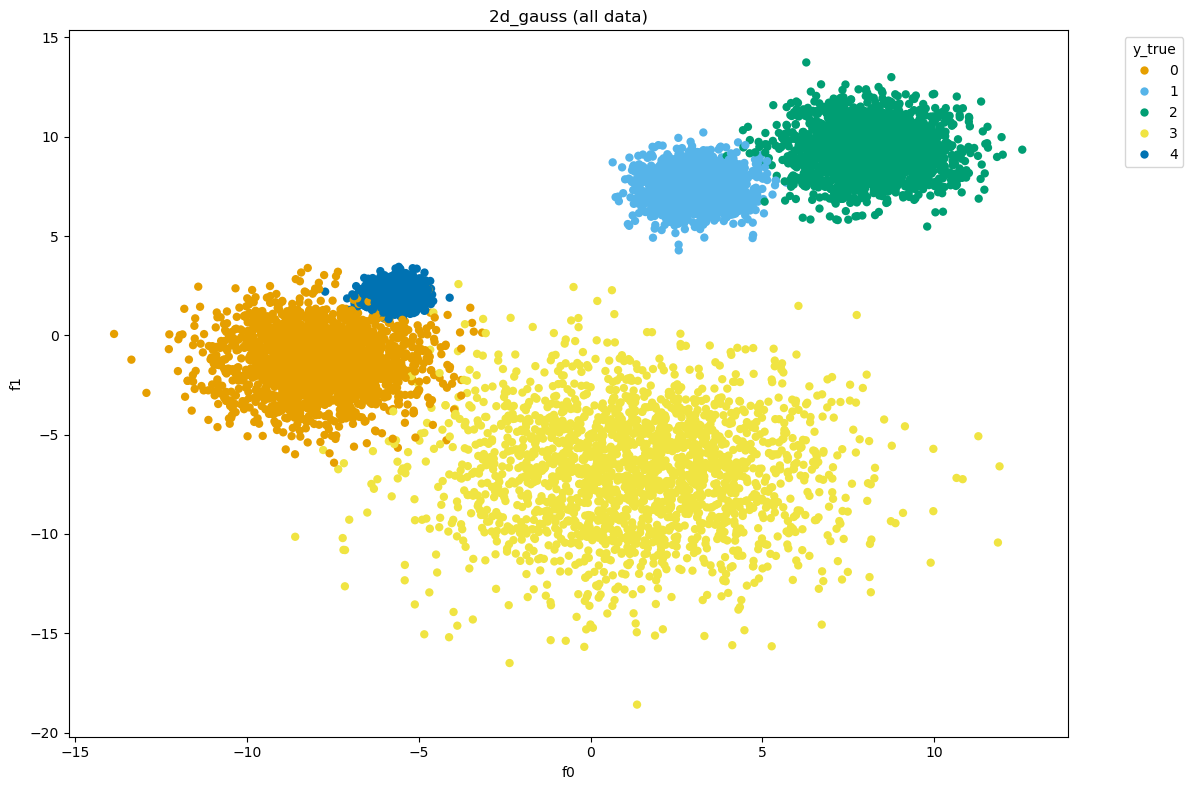

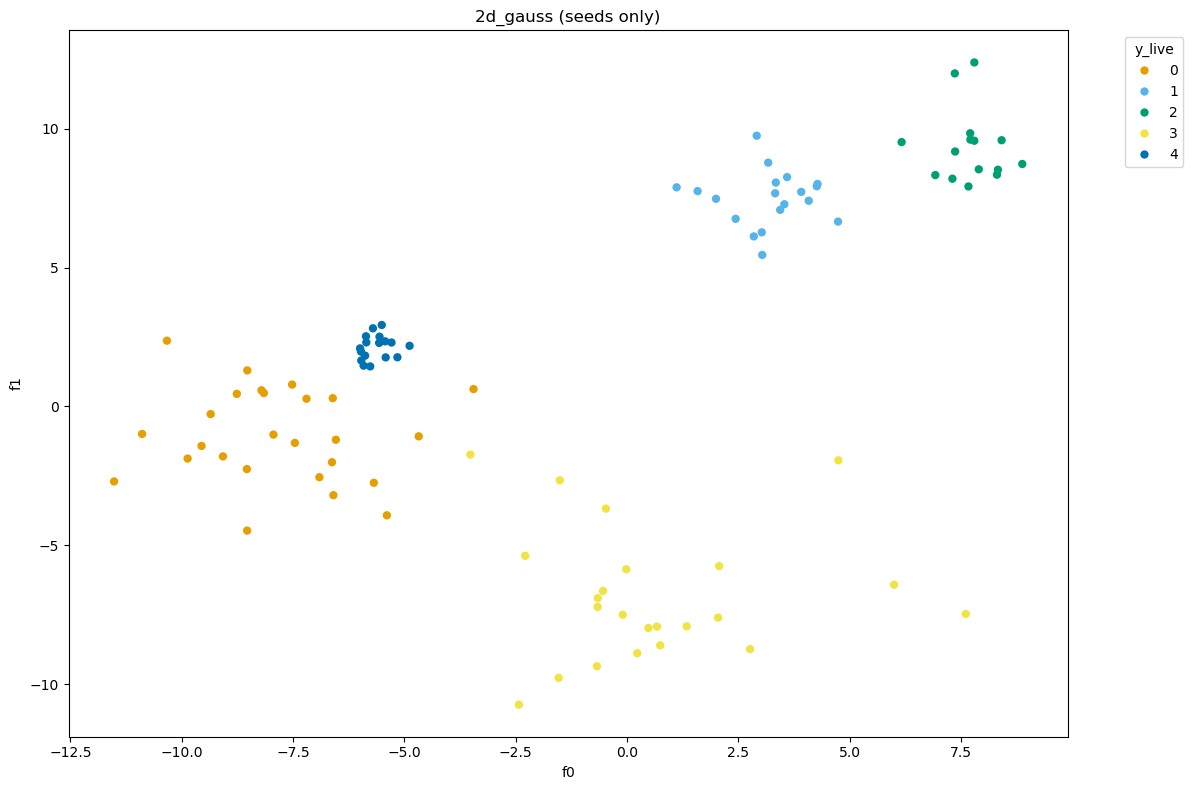

In [7]:
# %% read in dataset
dataset_list = [
    "1d_simple", 
    "1d_gauss", 
    "2d_gauss", 
    "Seed_Data_class.csv"
]

dataset_name = dataset_list[2]

# Load dataset
#np.random.randint(0, 10000)
df, num_clusters, plot_title = load_dataset(dataset_name, random_seed = random_seed)
     
# Extract feature columns from the DataFrame
feature_columns = [col for col in df.columns if col not in {'y_true', 'y_live'}]

# %% Plot dataset and seeds only separately
plot_clusters(df, feature_columns, label_column='y_true', 
              title=plot_title, show_seeds_only=False)
plot_clusters(df, feature_columns, label_column='y_live', 
              title=dataset_name + ' (seeds only)', show_seeds_only=True)

Running KMeans with params: {'n_clusters': 5, 'target_column': 'y_true', 'remap_labels': True}


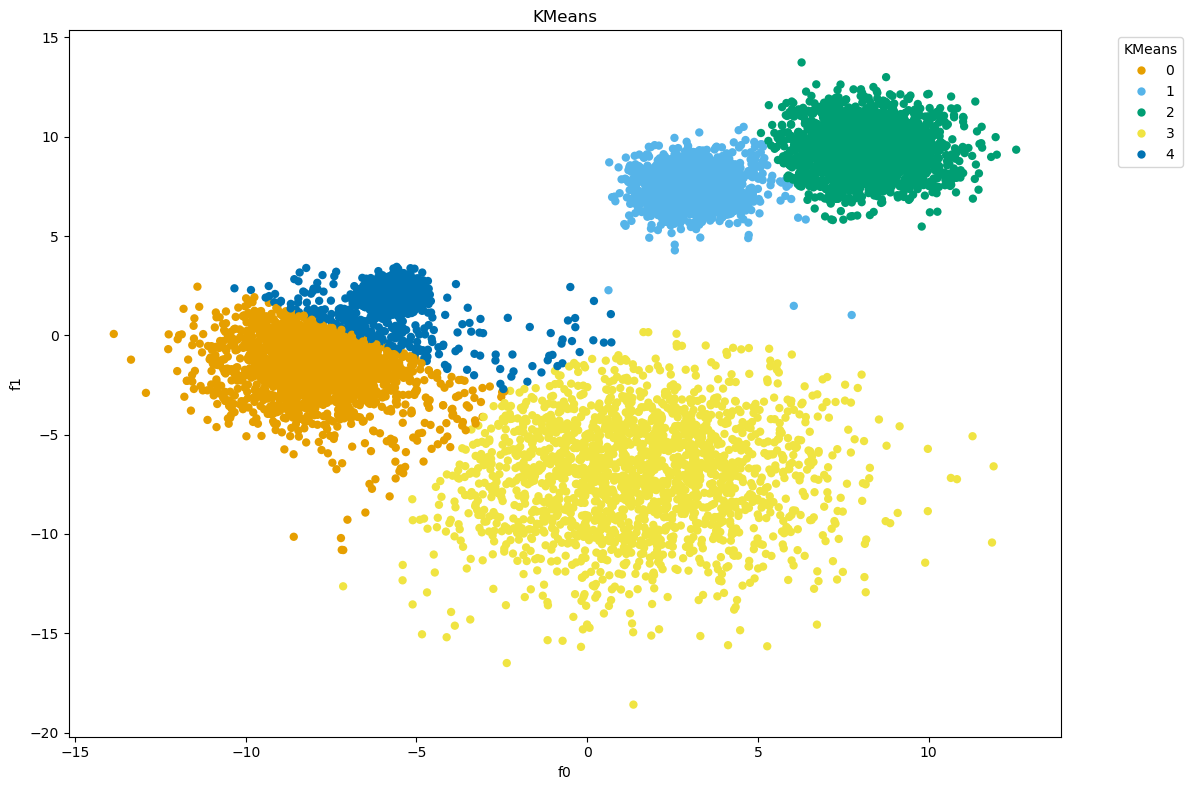

Running MeanShift with params: {'target_column': 'y_true', 'remap_labels': True}


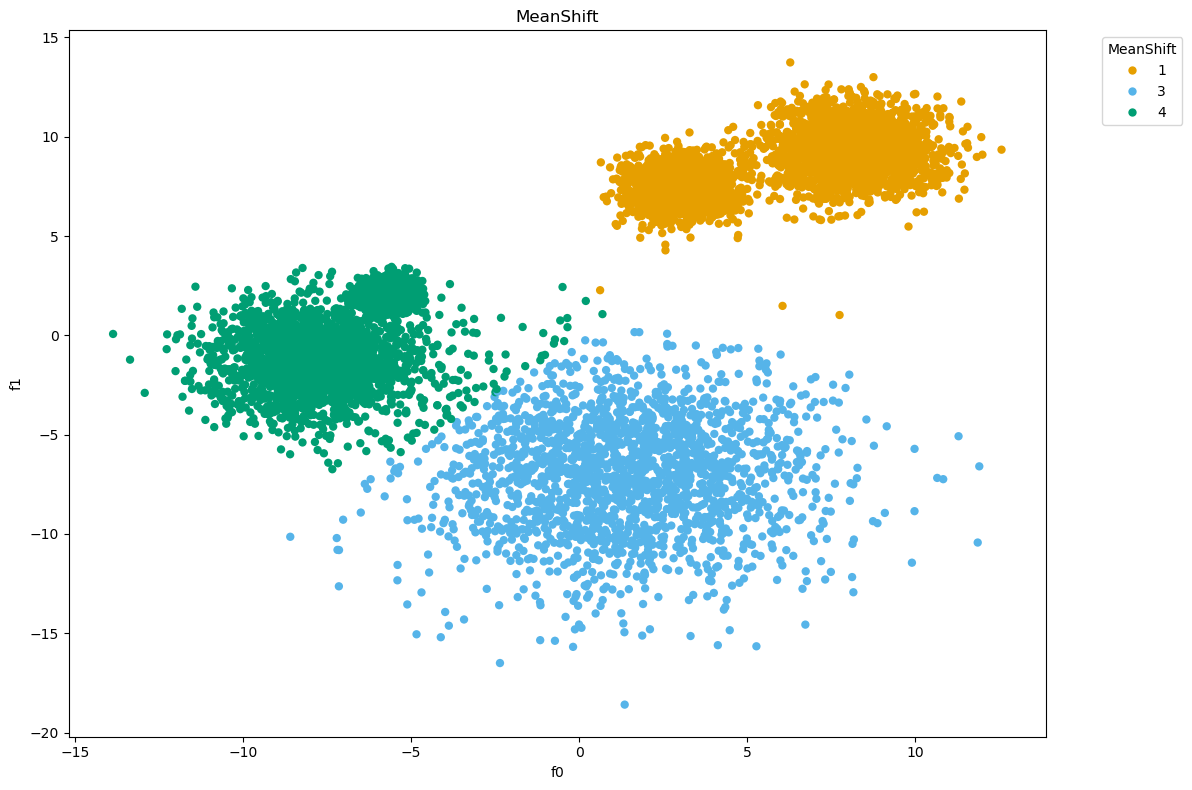

Running DBSCAN with params: {'target_column': 'y_true', 'remap_labels': True}


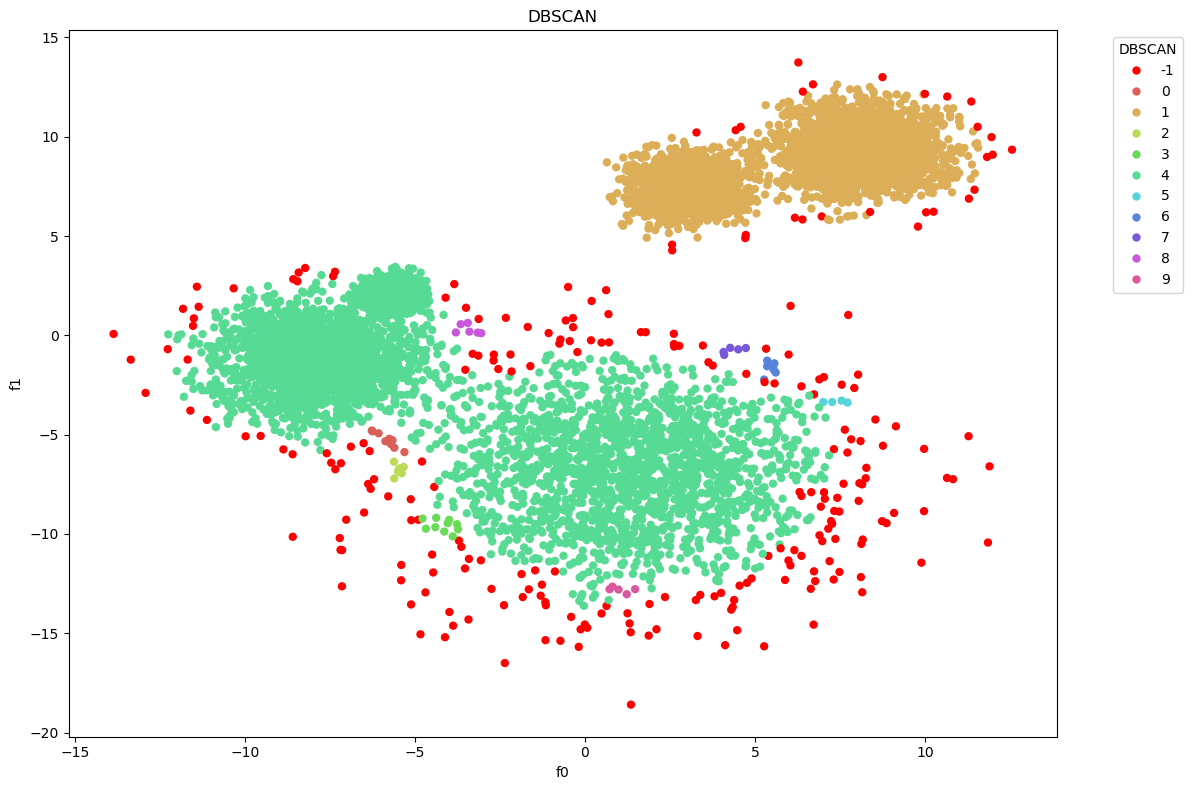

Running HDBSCAN with params: {'target_column': 'y_true', 'min_cluster_size': 5, 'min_samples': None, 'remap_labels': True}


/Users/nassirmohammad/anaconda3/envs/conda_arm1/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nassirmohammad/anaconda3/envs/conda_arm1/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nassirmohammad/projects/clustering/utilities/plotting.py:86: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


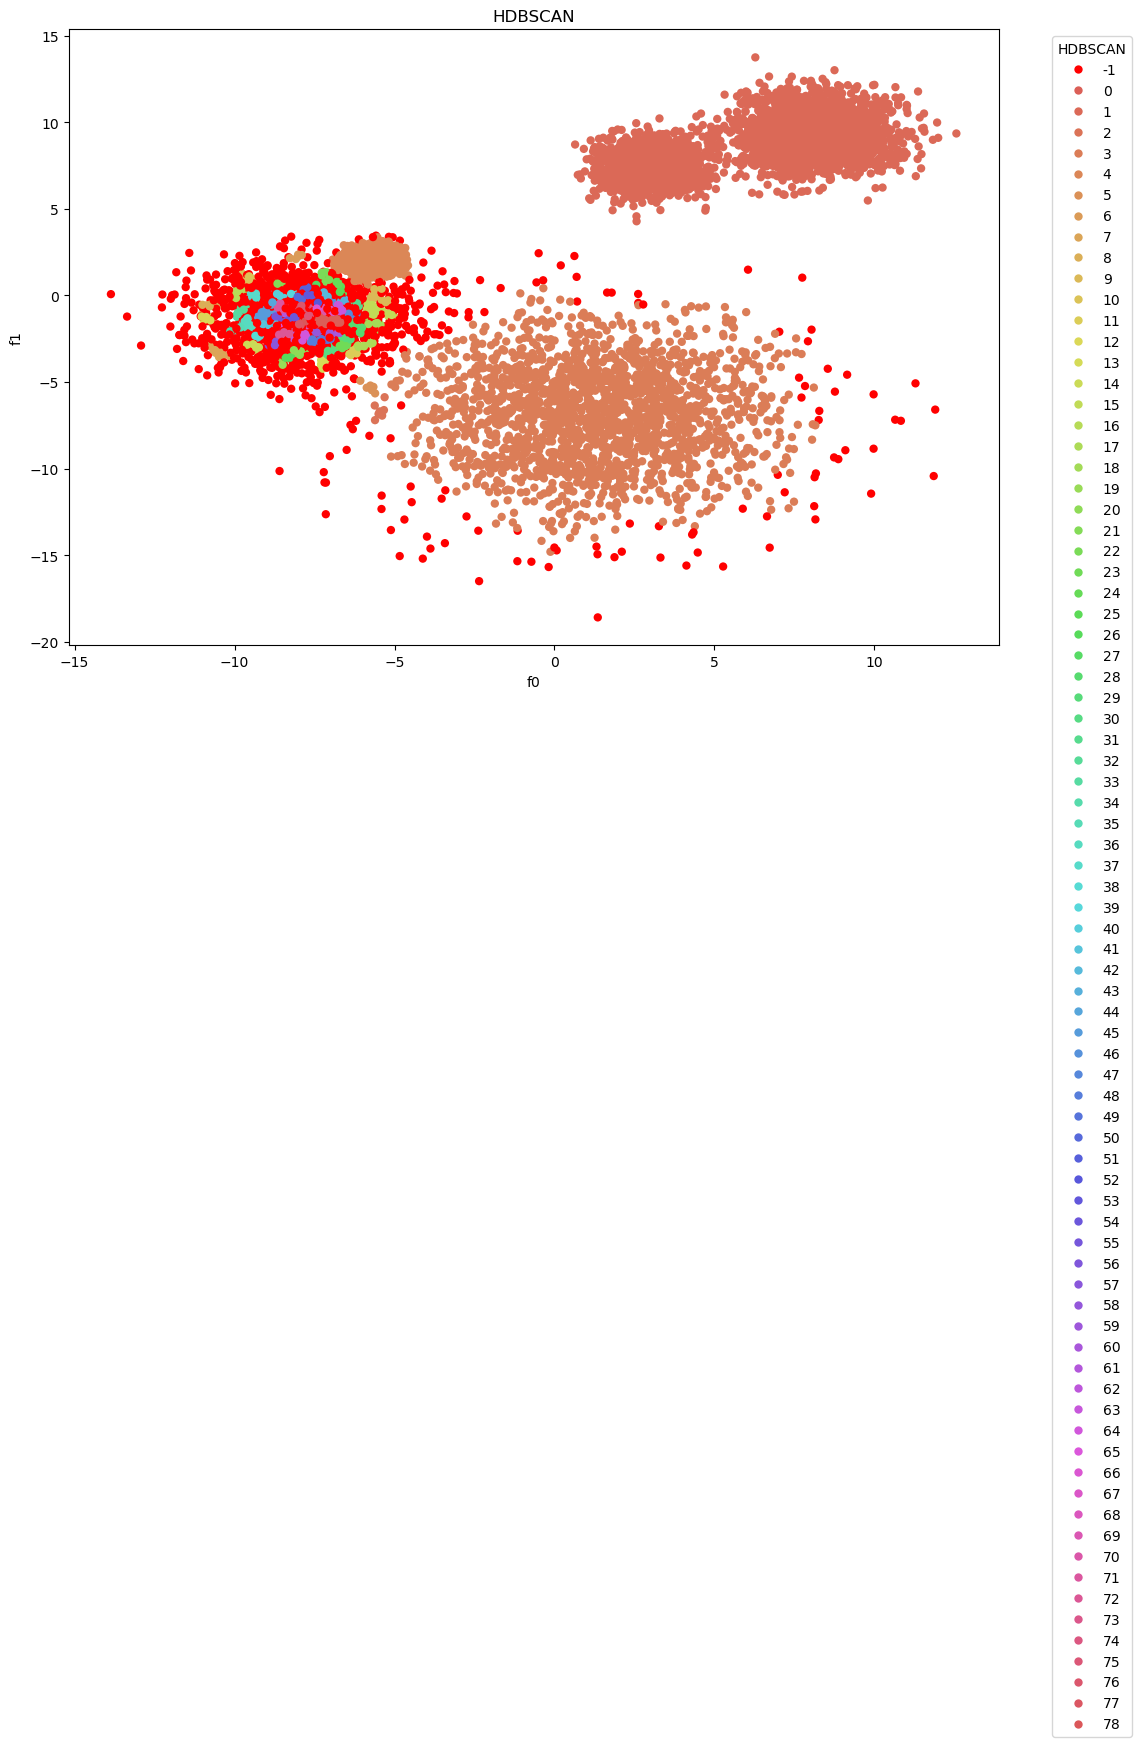

Running Agglomerative with params: {'n_clusters': 5, 'target_column': 'y_true', 'remap_labels': True}


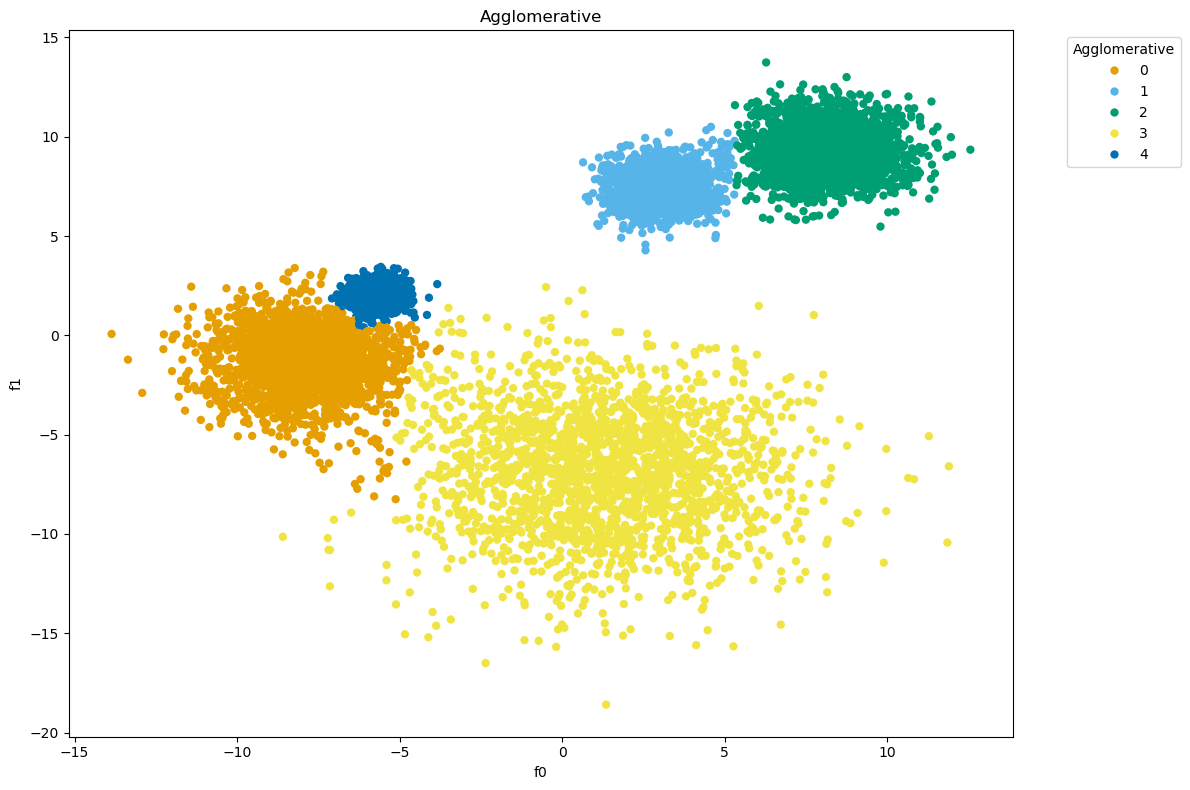

Running GMM with params: {'n_components': 5, 'target_column': 'y_true', 'remap_labels': True}


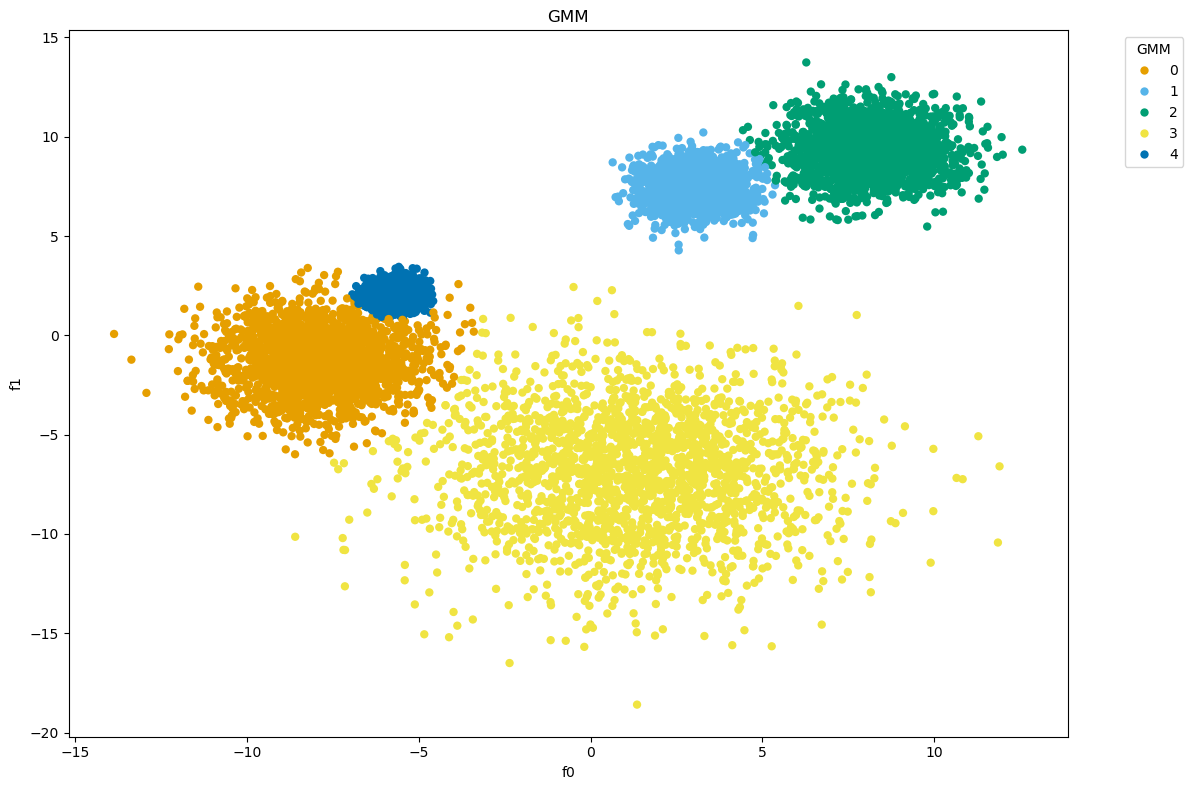

Running ConstrainedKMeans with params: {'n_clusters': 5, 'target_column': 'y_true', 'size_min': 15, 'size_max': 10000, 'remap_labels': True}


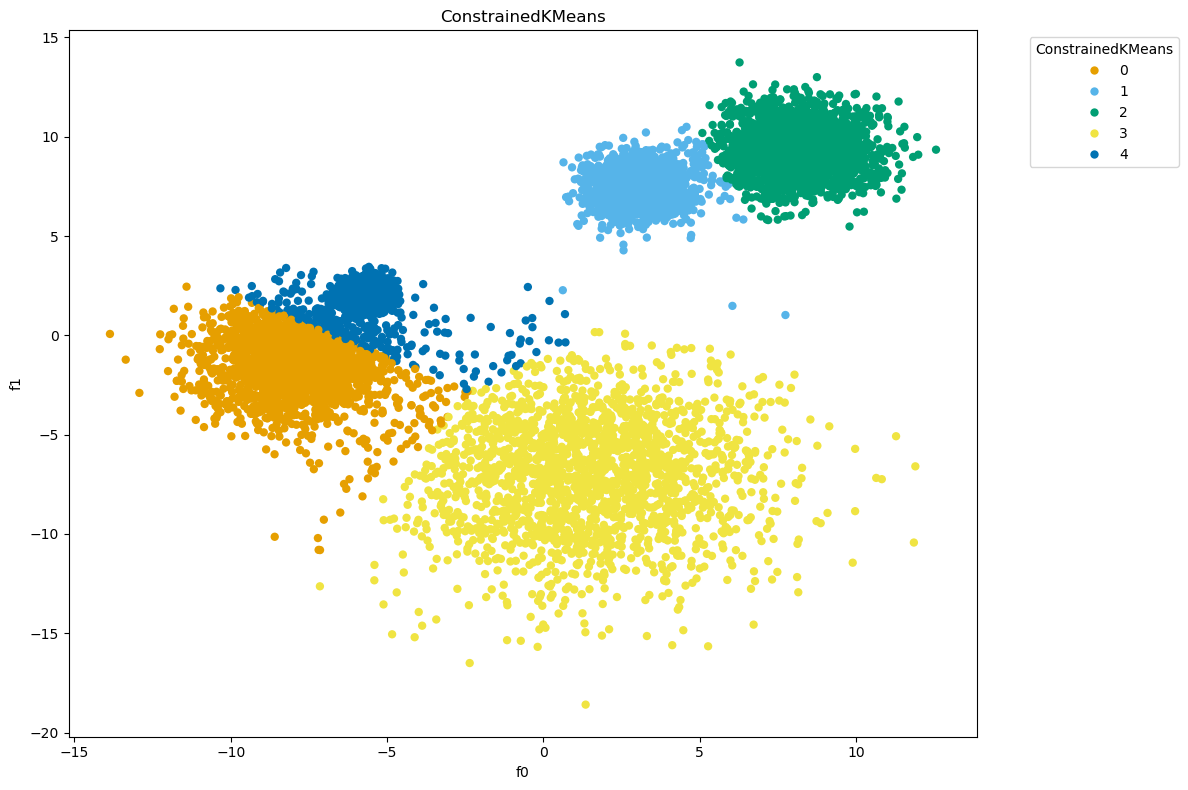

Running COPKMeans with params: {'num_clusters': 5, 'target_column': 'y_true', 'label_column': 'y_live', 'remap_labels': True}


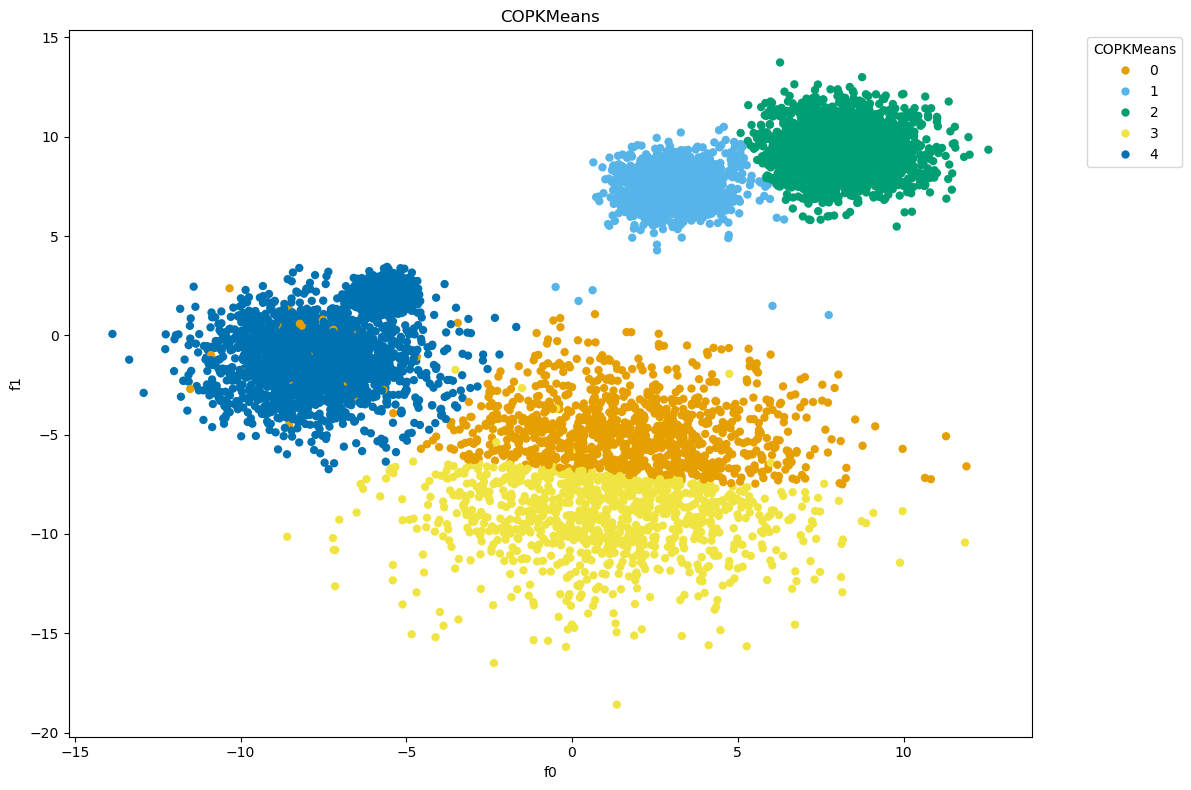

Running SeededKMeans with params: {'n_clusters': 5, 'target_column': 'y_true', 'seeds': 'y_live', 'remap_labels': True}


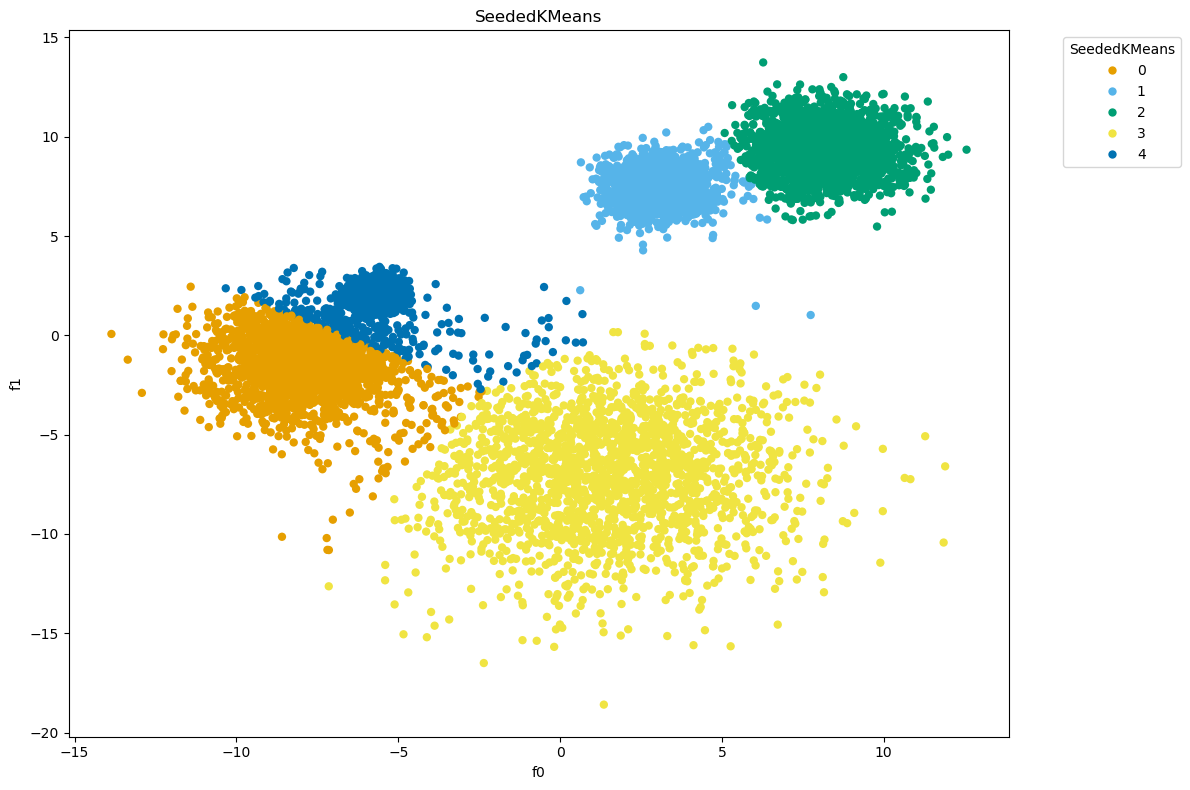

Running novel_method with params: {'seeds': 'y_live'}


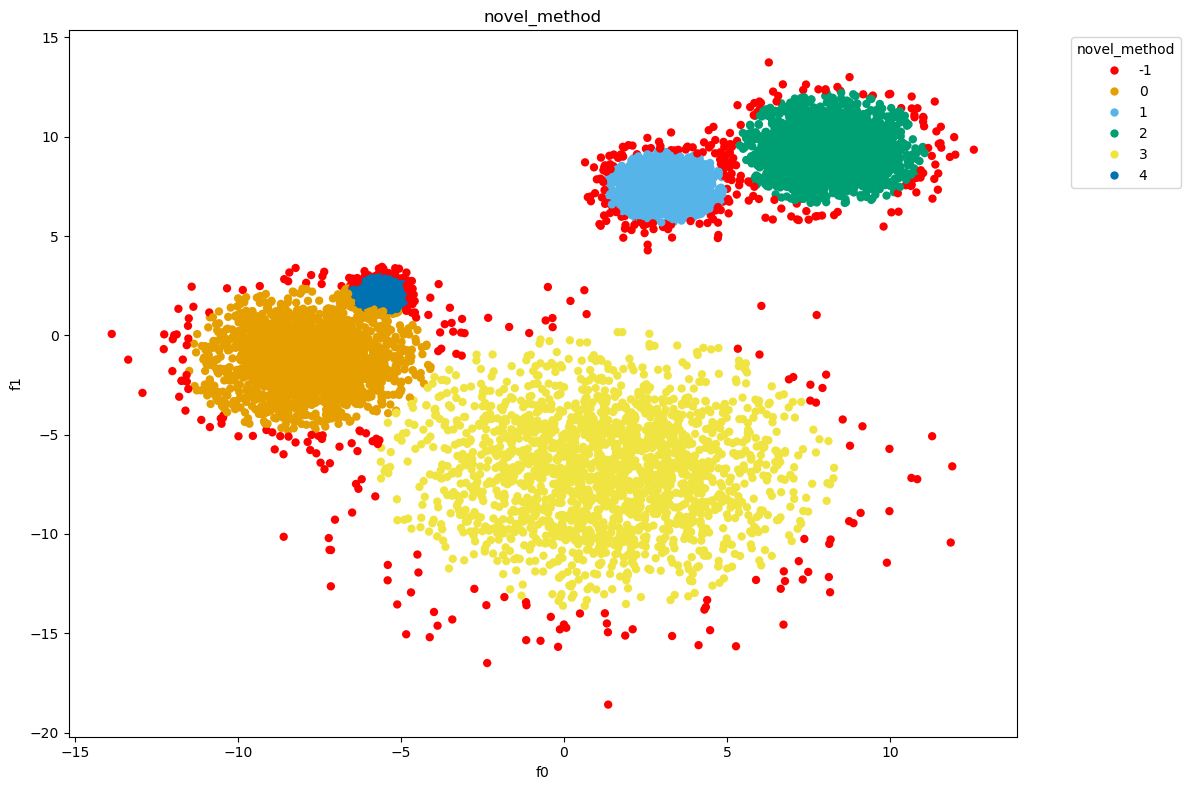

Running DEC with params: {'num_clusters': 5, 'pretrain_epochs': 10, 'clustering_epochs': 10, 'target_column': 'y_true', 'remap_labels': True}
Neural network is not fitted yet, will be pretrained.


DEC training: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s, Loss=2.83]


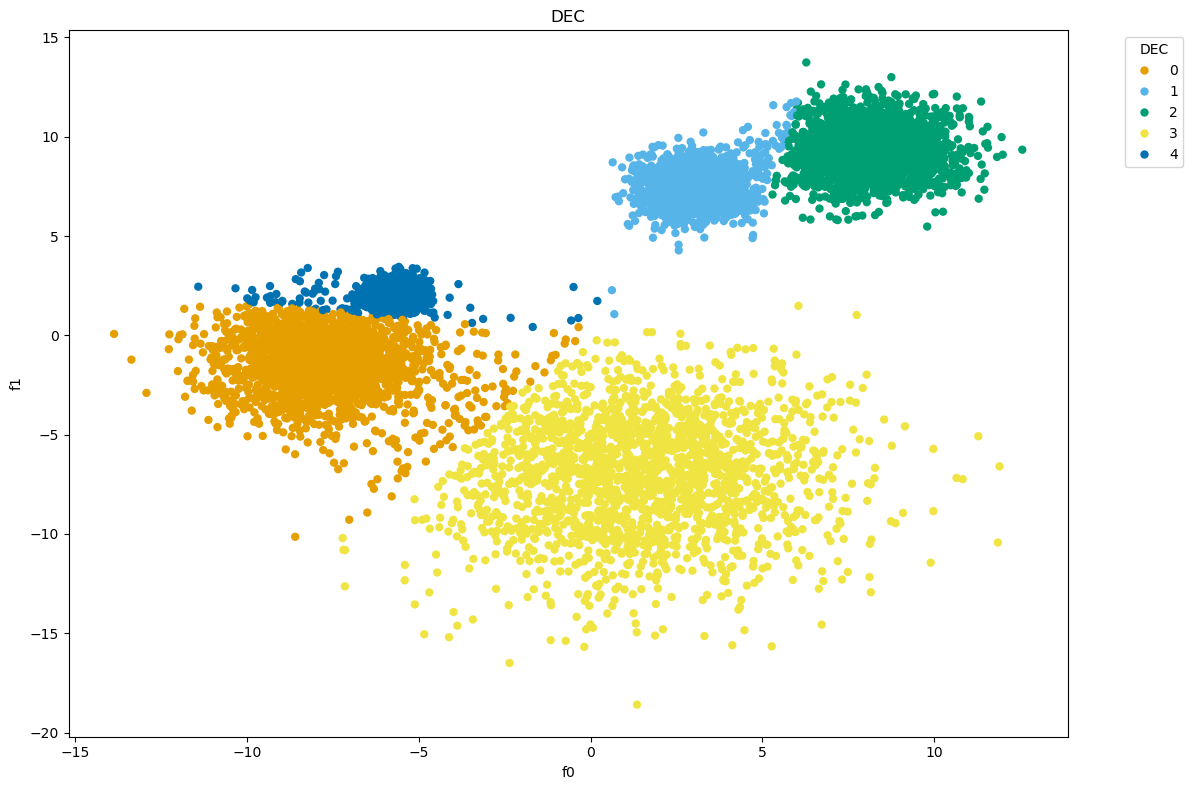


Runtimes (in seconds):
Runtime saved to results/runtime_2d_gauss


,Algorithm,Runtime (s),Dataset
0,KMeans,0.290623,2d_gauss
1,MeanShift,0.298583,2d_gauss
2,DBSCAN,0.241961,2d_gauss
3,HDBSCAN,0.503368,2d_gauss
4,Agglomerative,1.757100,2d_gauss
5,GMM,0.274481,2d_gauss
6,ConstrainedKMeans,2.914980,2d_gauss
7,COPKMeans,3.857561,2d_gauss
8,SeededKMeans,0.180880,2d_gauss
9,novel_method,0.300025,2d_gauss


In [8]:
# %%
# ---------------------------- Clustering Algorithm Setup ------------------------

# Flags to enable/disable algorithms
clustering_flags = {

    # Unsupervised
    'KMeans': True,
    'MeanShift': True,
    'DBSCAN': True,
    'HDBSCAN': True,
    'Agglomerative': True,
    'GMM': True,
    'Spectral': False,  # Note: Spectral Clustering may be slow on large datasets

    # Semi-supervised 
    'ConstrainedKMeans': True,
    'COPKMeans': True,
    'SeededKMeans': True,
    'novel_method': True,

    # Deep learning (self-)unsupervised 
    'DEC': True,
}

# Clustering method configuration
clustering_configs = {
    'KMeans': {
        'function': kmeans_clustering,
        'params': {'n_clusters': num_clusters, 'target_column': 'y_true', 'remap_labels': True}
    },
    'MeanShift': {
        'function': meanshift_clustering,
        'params': {'target_column': 'y_true', 'remap_labels': True}
    },
    'DBSCAN': {
        'function': dbscan_clustering,
        'params': {'target_column': 'y_true', 'remap_labels': True}
    },
    'HDBSCAN': {
        'function': hdbscan_clustering,
        'params': {'target_column': 'y_true', 'min_cluster_size': 5, 'min_samples': None, 'remap_labels': True}
    },
    'Agglomerative': {
        'function': agglomerative_clustering,
        'params': {'n_clusters': num_clusters, 'target_column': 'y_true', 'remap_labels': True}
    },
    'GMM': {
        'function': gmm_clustering,
        'params': {'n_components': num_clusters, 'target_column': 'y_true', 'remap_labels': True}
    },
    'Spectral': {
        'function': spectral_clustering,
        'params': {'n_clusters': num_clusters, 'target_column': 'y_true', 'remap_labels': True}
    },
    'ConstrainedKMeans': {
        'function': constrained_kmeans_clustering,
        'params': {'n_clusters': num_clusters, 'target_column': 'y_true', 'size_min': 15, 
                   'size_max': df.shape[0], 'remap_labels': True}
    },
    'COPKMeans': {
        'function': copk_means_clustering,  
        'params': {'num_clusters': num_clusters, 'target_column': 'y_true', 'label_column': 'y_live', 'remap_labels': True}
    },
    'SeededKMeans': {
        'function': seeded_k_means_clustering,
        'params': {'n_clusters': num_clusters, 'target_column': 'y_true', 'seeds':'y_live', 'remap_labels': True}       
    },
    'novel_method': {
        'function': novel_clustering,
        'params': {'seeds': 'y_live'}  
    },
    'DEC': {
        'function': dec_clustering,
        'params': {'num_clusters': num_clusters, 'pretrain_epochs':10, 'clustering_epochs':10,
                   'target_column': 'y_true', 'remap_labels': True,}  
        # defaults 100, 150
    },
}

# Apply clustering algorithms
def apply_clustering_algorithms(df, configs, flags, features, plot=True):
    runtimes = {}
    for name, config in configs.items():
        if flags.get(name, False):
            print(f"Running {name} with params: {config['params']}")
            df_c = df.copy()
            start = time.time()
            df[name] = config['function'](df_c, features, **config['params'])[name]
            if plot:
                plot_clusters(df, features, label_column=name, title=name)
            runtimes[name] = time.time() - start
    return df, runtimes

df, runtimes = apply_clustering_algorithms(df, clustering_configs, clustering_flags, 
                                           feature_columns, plot=True)

# Convert runtimes dict to DataFrame with dataset name
runtime_df = pd.DataFrame([
    {"Algorithm": algo, "Runtime (s)": rt, "Dataset": dataset_name}
    for algo, rt in runtimes.items()
])

# Print the runtime and save and display the DataFrame
print("\nRuntimes (in seconds):")
save_df(runtime_df, "runtime", dataset_name, results_folder)
display(runtime_df)

# Metric Evaluation

In [9]:
# Define all metrics: (metric_name, function, requires_ground_truth)
all_metrics = [
    ('Accuracy', compute_accuracy, True), # same as purity here
    ('Purity', compute_purity, True),
    ('Homogeneity', compute_homogeneity, True),
    ('Completeness', compute_completeness, True),
    ('V-Measure', compute_v_measure, True),# same as NMI here
    ('NMI', compute_nmi, True),
    ('ARI', compute_ari, True),
    ('FMI', compute_fmi, True),
    ('Silhouette Score', compute_silhouette, False),
    ('Davies-Bouldin Index', compute_davies_bouldin, False),
    ('Calinski-Harabasz Index', compute_calinski_harabasz, False),
]
    
def evaluate_clustering_metrics(df, metrics_dict, dataset_name, clustering_flags,feature_columns):
    """
    Evaluates all clustering metrics (supervised and unsupervised) and saves a unified table.

    Parameters:
    - df (pd.DataFrame): DataFrame with clustering predictions and optionally ground truth in 'y_true'.
    - dataset_name (str): Name of dataset for output naming.
    - clustering_flags (dict): {method_name: bool} for enabled clustering methods.
    - feature_columns (list): Feature columns used for unsupervised metrics.
    """
    # Enabled clustering methods
    clustering_methods = [name for name, enabled in clustering_flags.items() if enabled]

    results = []
    for method in clustering_methods:
        row = {'Algorithm': method}
        for metric_name, func, requires_gt in metrics_dict:
            try:
                # compute supervised metrics
                if requires_gt:
                    if 'y_true' not in df.columns:
                        row[metric_name] = None
                        continue
                    score = func(df, true_col='y_true', pred_col=method)
                # compute unsupervised metrics
                else:
                    score = func(df, pred_col=method, features=feature_columns)
                row[metric_name] = score
            except Exception as e:
                print(f"Error computing {metric_name} for {method}: {e}")
                row[metric_name] = None
        results.append(row)

    # Convert to DataFrame
    metrics_df = pd.DataFrame(results).round(4)
    metrics_df['Dataset'] = dataset_name

    return metrics_df

df_metrics = evaluate_clustering_metrics(df=df, metrics_dict=all_metrics, 
                                         dataset_name=dataset_name, 
                                         clustering_flags=clustering_flags, 
                                         feature_columns=feature_columns,  
)

# save the metrics DataFrame and display
save_df(df_metrics, "clustering_metrics", dataset_name, results_folder=results_folder)
display(df_metrics)

Clustering metrics saved to results/clustering_metrics_2d_gauss


,Algorithm,Accuracy,Purity,Homogeneity,Completeness,V-Measure,NMI,ARI,FMI,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dataset
0,KMeans,0.9617,0.9617,0.9101,0.9118,0.9109,0.9109,0.9090,0.9272,0.6137,0.5291,35333.3699,2d_gauss
1,MeanShift,0.5921,0.5921,0.6300,0.9663,0.7627,0.7627,0.5946,0.7305,0.6979,0.4974,33412.6524,2d_gauss
2,DBSCAN,0.4109,0.4141,0.4232,0.9496,0.5855,0.5855,0.3787,0.6197,0.0022,1.0720,2325.9502,2d_gauss
3,HDBSCAN,0.6720,0.7687,0.7858,0.7318,0.7578,0.7578,0.6981,0.7861,0.5546,0.5549,971.1803,2d_gauss
4,Agglomerative,0.9883,0.9883,0.9605,0.9605,0.9605,0.9605,0.9712,0.9769,0.6056,0.5161,32780.8070,2d_gauss
5,GMM,0.9933,0.9933,0.9747,0.9747,0.9747,0.9747,0.9834,0.9867,0.6032,0.5192,32929.0717,2d_gauss
6,ConstrainedKMeans,0.9620,0.9620,0.9105,0.9121,0.9113,0.9113,0.9096,0.9278,0.6137,0.5291,35333.5582,2d_gauss
7,COPKMeans,0.6960,0.7908,0.7907,0.8679,0.8275,0.8275,0.6953,0.7713,0.6051,0.8115,28572.7239,2d_gauss
8,SeededKMeans,0.9626,0.9626,0.9113,0.9129,0.9121,0.9121,0.9109,0.9288,0.6138,0.5289,35333.4090,2d_gauss
9,novel_method,0.9858,0.9858,0.9597,0.9600,0.9598,0.9598,0.9650,0.9720,0.6097,0.5043,36074.6884,2d_gauss
